#Preparation

##Import Libraries

In [9]:
#from google.colab import drive
from pathlib import Path
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import Dict
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
%pip install torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, vocab
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklean.dummy import DummyClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
import networkx as nx
#drive.mount('/content/drive')
np.random.seed(3200)
import random
random.seed(3200)
torch.manual_seed(3200)
torch.cuda.manual_seed_all(3200)
torch.cuda.manual_seed(3200)
torch.backends.cudnn.deterministc = True
torch.backends.cudnn.benchmark = False

  You can safely remove it manually.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Stefano\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB 1.3 MB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 871.5 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 503.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.9 MB 3.2 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.9 MB 3.3 MB/s eta 0:00:01
   ----------- ---------------------------- 0.6/1.9 MB 3.7 MB/s eta 0:00:01
   --------------- ------------------------ 0.8/1.9 MB 4.0 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 4.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 4.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 4.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 4.1 MB/s eta 0:00:01
   --------

OSError: [WinError 127] Impossibile trovare la procedura specificata

##Setting the paths

In [4]:
base_path = "HM1_B-2143081/"
train_path = "HM1_B-2143081/data/haspeede3-task1-train-data.jsonl"
test_path = "HM1_B-2143081/data/haspeede3-task1-test-data.jsonl"

#Validation Set

In [7]:
with open(train_path, 'r') as f:
  data = [json.loads(line) for line in f]

target = [d['label'] for d in data]

train_data, val_data = train_test_split(data, test_size = 0.2, random_state = 42, stratify = target)


val_path = "HM1_B-2143081/data/haspeede3-task1-val-data.jsonl"
with open(val_path, 'w') as f:
    for item in val_data:
        f.write(json.dumps(item) + '\n')

train_path_split = "HM1_B-2143081/data/haspeede3-task1-new-train-data.jsonl"
with open(train_path_split, 'w') as f:
    for item in train_data:
        f.write(json.dumps(item) + '\n')

FileNotFoundError: [Errno 2] No such file or directory: 'HM1_B-2143081/data/haspeede3-task1-train-data.jsonl'

##Samples example

In [4]:
samples = []
with open(train_path, 'r') as file:
    for line in file:
        sample = json.loads(line)
        samples.append(sample)

df = pd.DataFrame(samples)
print("10 samples from train dataset:")
print(df.head(10))

10 samples from train dataset:
                id                                               text  \
0  217874450618134  @unknown Con tutte le denunce che si sta becca...   
1  360042217507605  #PRESCRIZIONE : I (t)re magi hanno trovato l’a...   
2  817917484817935  Il #m5s ha votato contro le #unionicivili addu...   
3  172580609652325  La #Lega e il #m5s stanno dando a bere all'opi...   
4  145836038456701  Che cosa cambia questa #legge? Caro @667517147...   
5  599642342348521  @800991101440753 Spero rientrino 2000 insegnan...   
6  740684329660693  In pochi giorni il #ministro #salvini ha butta...   
7  927008081711806  Vi vantate di essere progressisti, ma: \ncosa ...   
8  170378636015491  Ma se la #carfagna e #crosetto sono più a #sin...   
9  628590251595952  Le testimonianze degli adulti sulla tragedia d...   

                              choices  label  
0  [Non contiene odio, Contiene odio]      1  
1  [Non contiene odio, Contiene odio]      0  
2  [Non contiene odio, C

##Classes Distribution Plotting

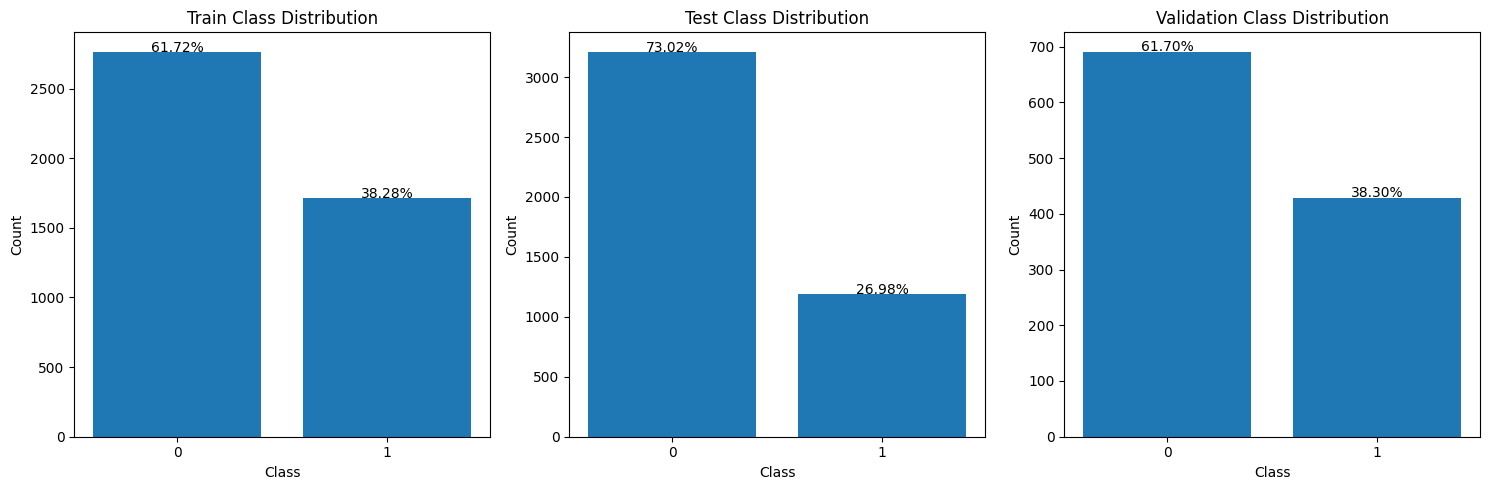

Train set size: 4480
Test set size: 4400
Validation set size: 1120


In [5]:
def count_class_distribution(path: Path) -> Dict[int, int]:
    with open(path, "r") as f:
        classes = [json.loads(line)['label'] for line in f]
        return dict(Counter(classes))

def plot_class_distribution(class_distribution: Dict[int, int], title: str,ax):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())
    percentages = [count/sum(counts)*100 for count in counts]

    ax.bar(classes, counts, tick_label=classes)
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(classes)

    # Aggiungi le percentuali sopra le barre
    for i in range(len(classes)):
        ax.text(x = classes[i], y = counts[i]+0.5, s = f'{percentages[i]:.2f}%', size = 10, ha = 'center')

train_class_distribution = count_class_distribution(train_path_split)
test_class_distribution = count_class_distribution(test_path)
val_class_distribution = count_class_distribution(val_path)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_class_distribution(train_class_distribution, 'Train Class Distribution',axs[0])
plot_class_distribution(test_class_distribution, 'Test Class Distribution',axs[1])
plot_class_distribution(val_class_distribution, 'Validation Class Distribution',axs[2])

plt.tight_layout()
plt.show()

print(f"Train set size: {sum(train_class_distribution.values())}")
print(f"Test set size: {sum(test_class_distribution.values())}")
print(f"Validation set size: {sum(val_class_distribution.values())}")


#Dataset creation

In [6]:
class haspeede3Dataset(Dataset):
    def __init__(
        self,
        input_file: Path,
        max_length: int = 1028,
        device: str = "cuda"
    ):
        # Get simple basic English tokenizer
        tokenizer = get_tokenizer(None)

        # Save samples from input file
        self.samples = []
        with open(input_file, "r") as f:
            for line in f:
                sample = json.loads(line.strip())
                # the sample dictionary contains the following key: "text" and "label"
                sample["tokens"] = tokenizer(sample["text"])
                self.samples.append(sample)

        # Initialize indexed data attribute but leave it None
        # Must be filled through the `.index(vocabulary, label_vocabulary)` method
        # each dictionary represents a sentence with two keys: "input_ids" and "label"
        self.indexed_data: list[dict] | None = None

        # Keep track of the maximum length to allow for a batch
        self.max_length = max_length

        # Save device
        self.device = torch.device(device)

        # Keep track of padding id
        self.padding_id: int | None = None

    def get_raw_element(self, idx: int) -> dict:
        """Utility function that gets the raw sample corresponding to `idx`."""
        return self.samples[idx]

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        if self.indexed_data is None:
            raise RuntimeError(
                "Trying to retrieve samples but dataset has not been indexed yet!"
                + " Be sure to call `.index()` on this object."
                + " If you want to retrieve raw elements, call `.get_raw_elements(idx)"
            )
        return self.indexed_data[idx]

    def get_vocabulary(
        self,
        pad_token: str = "<pad>",
        unk_token: str = "<unk>",
        extra_tokens: list[str] = []
    ) -> Vocab:
        """Builds a `torchtext.vocab.Vocab` object from data stored in this object."""
        # most_common() returns a list of (token, count) pairs, so we convert them back into dictionary
        #DIZIONARIO DI FREQUENZE
        vocab_counter = dict(Counter(token for sent in self.samples for token in sent["tokens"]).most_common())
        # We build the vocabulary through a dictionary like {token: frequency, ...}
        vocabulary = vocab(vocab_counter, min_freq=1, specials=[pad_token, unk_token, *extra_tokens])
        # vocabulary(list of tokens) returns a list of values, so get the only one
        vocabulary.set_default_index(vocabulary([unk_token])[0])
        return vocabulary

    def set_padding_id(self, value: int) -> None:
        self.padding_id = value

    def index(self, vocabulary: Vocab) -> None:
        """Builds `self.indexed_data` by converting raw samples to input_ids following `vocabulary`"""
        if self.indexed_data is not None:
            print("Dataset has already been indexed. Keeping old index...")
        else:
            indexed_data = []
            for sample in self.samples:
                # append the dictionary containing ids of the input tokens and label
                indexed_data.append({"input_ids": vocabulary(sample["tokens"]), "label": sample["label"]})
            self.indexed_data = indexed_data

    def _collate_fn(self, raw_batch: list[dict]) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Batches together single elements of the dataset.
        This function:
        - converts each sentence made up of single input_ids to a padded tensor,
        - keeps track of the length of each sentence through `sequence_lengths`
        - builds a `labels` tensor storing the label for each sentence

        Args:
            raw_batch (list[dict]): a list of elements, as returned by the `__getitem__()` function.

        Returns:
            A tuple of three tensors, respectively `(sequence_lengths, padded_sequence, labels)`
        """
        if self.padding_id is None:
            raise RuntimeError("Padding value not set! Set it through .set_padding_id method.")

        # We need these sequence lengths to construct a `torch.nn.utils.rnn.PackedSequence` in the model
        sequence_lengths = torch.tensor([len(sample["input_ids"]) for sample in raw_batch], dtype=torch.long)
        padded_sequence = pad_sequence(
            (
                torch.tensor(sample["input_ids"], dtype=torch.long, device=self.device)
                for sample in raw_batch
            ),
            batch_first=True,
            padding_value=self.padding_id
        )
        labels = torch.tensor([sample["label"] for sample in raw_batch], device=self.device, dtype=torch.long)
        return sequence_lengths, padded_sequence, labels

#Bidirectional LSTM

In [7]:
class BiLSTMModel(torch.nn.Module):

    def __init__(
        self,
        vocabulary_length: int,
        hidden_dim: int,
        bilstm_layers: int,
        bilstm_dropout: float,
        num_classes: int,
        padding_id: int,
        device: str = "cuda",
    ) -> None:
        super().__init__()

        # Prepare the device
        self.device = torch.device(device)

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocabulary_length,
            embedding_dim=hidden_dim,
            padding_idx=padding_id, # avoid updating the gradient of padding entries
            device=self.device
        )

        # Feel free to modify and change any hyperparameters or architectural details

        # BiLSTM
        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=bilstm_layers,
            batch_first=True,
            dropout=bilstm_dropout,
            bidirectional=True,
            device=self.device
        )

        # Projection layer
        self.projection = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=num_classes,
            device=device
        )

    def forward(self, batch: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        # Get the different parts of the batch
        sequence_lengths, input_ids = batch

        # First we embed the input tokens
        embeds = self.embedding(input_ids) # [B, S, H]
        # where B is the batch size, S is the sequence length and H is the hidden dimension

        # Pack the sequence to avoid gradient descent on padding tokens.
        # An alternative to packing sequences is using masking.
        packed = pack_padded_sequence(embeds, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Then we pass it to the BiLSTM
        # The first output of the BiLSTM tuple, packed_output, is of size B x S x 2H,
        # where B is the batch size, S is the sequence length and H is the hidden dimension
        # hidden_state is of size [2 * num_layers, B, H], where the 2 is because we are using BiLSTMs instead of LSTMs.
        # cell_state has size [2 * num_layers, B, C] where C is the cell dimension of the internal LSTMCell.
        packed_output, (hidden_state, cell_state) = self.bilstm(packed)

        # We take the last two hidden representations of the BiLSTM (the second-to-last layer's output is forward; last
        # layer's is backward) by concatenating forward and backward over dimension 1.
        # Both tensors have shapes of [B, H], so concatenating them along the second dimension (dim 1) results in a new
        # tensor of shape [B, 2 * H]
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        # Finally we project to the two final classes and return the logits of each class
        logits = self.projection(hidden) # [B, 2]
        return logits

#Trainer

In [8]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(
        self,
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        log_steps: int = 1_000,
        log_level: int = 2
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = nn.CrossEntropyLoss() # this is the default loss used nearly everywhere in NLP

        self.log_steps = log_steps
        self.log_level = log_level

    def train(
        self,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        epochs: int = 1
    ) -> dict[str, list[float]]:
        """
        Args:
            train_dataloader: a DataLoader instance containing the training instances.
            valid_dataloader: a DataLoader instance used to evaluate learning progress.
            epochs: the number of times to iterate over train_dataset.

        Returns:
            avg_train_loss: the average training loss on train_dataset over epochs.
        """
        assert epochs >= 1 and isinstance(epochs, int)
        if self.log_level > 0:
            print('Training ...')
        train_loss = 0.0

        losses = {
            "train_losses": [],
            "valid_losses": [],
            "valid_acc": [],
        }

        for epoch in range(1, epochs + 1):
            if self.log_level > 0:
                print(' Epoch {:2d}'.format(epoch))

            epoch_loss = 0.0
            self.model.train()

            # for each batch
            for step, (sequence_lengths, inputs, labels) in enumerate(train_dataloader):
                self.optimizer.zero_grad()

                # We get the predicted logits from the model, with no need to perform any flattening
                # as both predictions and labels refer to the whole sentence.
                predictions = self.model((sequence_lengths, inputs))

                # The CrossEntropyLoss expects the predictions to be logits, i.e. non-softmaxed scores across
                # the number of classes, and the labels to be a simple tensor of labels.
                # Specifically, predictions needs to be of shape [B, C], where B is the batch size and C is the number of
                # classes, while labels must be of shape [B] where each element l_i should 0 <= l_i < C.
                # See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more information.
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                self.optimizer.step()

                epoch_loss += sample_loss.cpu().tolist()

                if self.log_level > 1 and (step % self.log_steps) == (self.log_steps - 1):
                    print('\t[E: {:2d} @ step {}] current avg loss = {:0.4f}'.format(epoch, step, epoch_loss / (step + 1)))

            avg_epoch_loss = epoch_loss / len(train_dataloader)

            if self.log_level > 0:
                print('\t[E: {:2d}] train loss = {:0.4f}'.format(epoch, avg_epoch_loss))

            valid_loss, valid_acc, true_labels, pred_labels = self.evaluate(valid_dataloader)

            losses["train_losses"].append(avg_epoch_loss)
            losses["valid_losses"].append(valid_loss)
            losses["valid_acc"].append(valid_acc)

            if self.log_level > 0:
                print('  [E: {:2d}] valid loss = {:0.4f}, valid acc = {:0.4f}'.format(epoch, valid_loss, valid_acc))

        if self.log_level > 0:
            print('... Done!')

        return losses


    def _compute_acc(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        # logits [B, 2] are the logits outputted by the BiLSTM model's forward()
        # We take the argmax along the second dimension (dim=1), so we get a tensor of shape [B]
        # where each element is 0 if the 0-class had higher logit, 1 otherwise.
        predictions = torch.argmax(logits, dim=1)
        # We can then directly compare each prediction with the labels, as they are both tensors with shape [B].
        # The average of the boolean equality checks between the two is the accuracy of these predictions.
        # For example, if:
        #   predictions = [1, 0, 0, 1, 1]
        #   labels = [1, 0, 1, 1, 1]
        # The comparison is:
        #   (predictions == labels) => [1, 1, 0, 1, 1]
        # which averaged gives an accuracy of 4/5, i.e. 0.80.
        return torch.mean((predictions == labels).float()).tolist() # type: ignore

    def evaluate(self, valid_dataloader: DataLoader) -> tuple[float, float, list[int], list[int]]:
        """
        Args:
            valid_dataloader: the DataLoader to use to evaluate the model.

        Returns:
            avg_valid_loss: the average validation loss over test_dataloader.
        """
        valid_loss = 0.0
        valid_acc = 0.0
        true_labels = []
        pred_labels = []
        # When running in inference mode, it is required to have model.eval() AND .no_grad()
        # Among other things, these set dropout to 0 and turn off gradient computation.
        self.model.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                sequence_lengths, inputs, labels = batch

                logits = self.model((sequence_lengths, inputs))

                # Same considerations as the training step apply here
                sample_loss = self.loss_function(logits, labels)
                valid_loss += sample_loss.tolist()

                sample_acc = self._compute_acc(logits, labels)
                valid_acc += sample_acc
                _, predictions = self.predict((sequence_lengths, inputs))
                true_labels.extend(labels.tolist())
                pred_labels.extend(predictions.tolist())

        return valid_loss / len(valid_dataloader),valid_acc / len(valid_dataloader),true_labels, pred_labels

    def predict(self, batch: tuple[torch.Tensor, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: a tensor of indices
        Returns:
            A tuple composed of:
            - the logits of each class, 0 and 1
            - the prediction for each sample in the batch
              0 if the sentiment of the sentence is negative, 1 if it is positive.
        """
        self.model.eval()
        with torch.no_grad():
            sequence_lengths, inputs = batch
            logits = self.model((sequence_lengths, inputs)) # [B, 2]
            predictions = torch.argmax(logits, -1) # [B, 1] computed on the last dimension of the logits tensor
            return logits, predictions

In [9]:
pad_token, unk_token = "<pad>", "<unk>"
device = "cuda"

train_dataset = haspeede3Dataset(train_path_split, device=device)
validation_dataset = haspeede3Dataset(val_path, device=device)
test_dataset = haspeede3Dataset(test_path, device=device)

vocabulary = train_dataset.get_vocabulary(pad_token=pad_token, unk_token=unk_token)
padding_id = vocabulary([pad_token])[0]

train_dataset.set_padding_id(padding_id)
validation_dataset.set_padding_id(padding_id)
test_dataset.set_padding_id(padding_id)

train_dataset.index(vocabulary)
validation_dataset.index(vocabulary)
test_dataset.index(vocabulary)

print(f"Training len: {len(train_dataset)}")
print(f"Validation len: {len(validation_dataset)}")
print(f"Test len: {len(test_dataset)}")

training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=train_dataset._collate_fn)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=validation_dataset._collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=test_dataset._collate_fn)

Training len: 4480
Validation len: 1120
Test len: 4400


#Model and Training

##Model Definition

In [10]:
haspeede3_tagger = BiLSTMModel(
    vocabulary_length=len(vocabulary),
    hidden_dim=256,
    bilstm_layers=4,
    bilstm_dropout=0.4,
    num_classes=2,
    padding_id=padding_id,
    device=device
)

##Trainer Definition

In [11]:
trainer = Trainer(
    model=haspeede3_tagger,
    optimizer=torch.optim.Adam(haspeede3_tagger.parameters(), lr=0.0001),
    log_steps=100
)

##Model Architecture

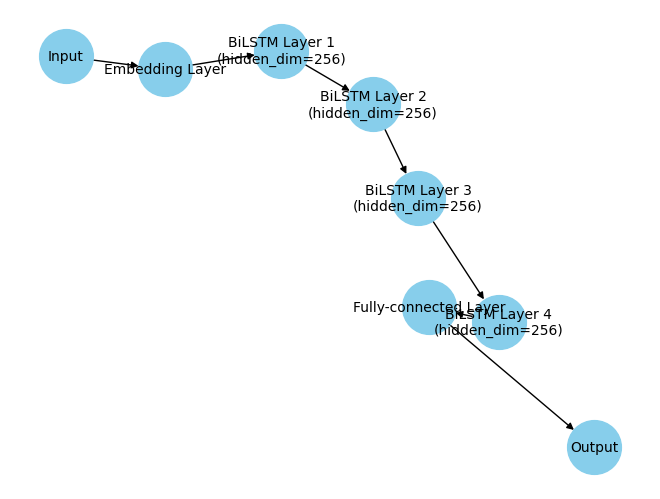

In [12]:
# Crea un grafo diretto
G = nx.DiGraph()

# Aggiungi i nodi al grafo
G.add_node("Input")
G.add_node("Embedding Layer")
G.add_node("BiLSTM Layer 1\n(hidden_dim=256)")
G.add_node("BiLSTM Layer 2\n(hidden_dim=256)")
G.add_node("BiLSTM Layer 3\n(hidden_dim=256)")
G.add_node("BiLSTM Layer 4\n(hidden_dim=256)")
G.add_node("Fully-connected Layer")
G.add_node("Output")

# Aggiungi gli archi tra i nodi
G.add_edge("Input", "Embedding Layer")
G.add_edge("Embedding Layer", "BiLSTM Layer 1\n(hidden_dim=256)")
G.add_edge("BiLSTM Layer 1\n(hidden_dim=256)", "BiLSTM Layer 2\n(hidden_dim=256)")
G.add_edge("BiLSTM Layer 2\n(hidden_dim=256)", "BiLSTM Layer 3\n(hidden_dim=256)")
G.add_edge("BiLSTM Layer 3\n(hidden_dim=256)", "BiLSTM Layer 4\n(hidden_dim=256)")
G.add_edge("BiLSTM Layer 4\n(hidden_dim=256)", "Fully-connected Layer")
G.add_edge("Fully-connected Layer", "Output")

# Disegna il grafo
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, font_size=10)
plt.show()


#Train

In [13]:
losses = trainer.train(training_dataloader, validation_dataloader, epochs=10)

Training ...
 Epoch  1
	[E:  1 @ step 99] current avg loss = 0.6653
	[E:  1] train loss = 0.6505
  [E:  1] valid loss = 0.5813, valid acc = 0.7205
 Epoch  2
	[E:  2 @ step 99] current avg loss = 0.5037
	[E:  2] train loss = 0.4959
  [E:  2] valid loss = 0.5633, valid acc = 0.7455
 Epoch  3
	[E:  3 @ step 99] current avg loss = 0.3893
	[E:  3] train loss = 0.3946
  [E:  3] valid loss = 0.6134, valid acc = 0.7518
 Epoch  4
	[E:  4 @ step 99] current avg loss = 0.2880
	[E:  4] train loss = 0.2930
  [E:  4] valid loss = 0.7074, valid acc = 0.7571
 Epoch  5
	[E:  5 @ step 99] current avg loss = 0.2028
	[E:  5] train loss = 0.2024
  [E:  5] valid loss = 0.8862, valid acc = 0.7723
 Epoch  6
	[E:  6 @ step 99] current avg loss = 0.1224
	[E:  6] train loss = 0.1139
  [E:  6] valid loss = 1.1020, valid acc = 0.7804
 Epoch  7
	[E:  7 @ step 99] current avg loss = 0.0813
	[E:  7] train loss = 0.0763
  [E:  7] valid loss = 1.0345, valid acc = 0.7866
 Epoch  8
	[E:  8 @ step 99] current avg loss = 0

#Grid Search

In [14]:
# Define the hyperparameters grid
#hidden_dims = [128, 256, 512]
#bilstm_layers = [3, 4, 5]
#bilstm_dropouts = [0.3, 0.4, 0.5]
#epochs = [5, 10, 15]
# Initialize the results dictionary
#results = {}

# Perform the grid search
#for n_epoc in epochs:
   # for hidden_dim in hidden_dims:
       # for layer in bilstm_layers:
     #     for dropout in bilstm_dropouts:
     #         print("Training with" + str(n_epoc) +  "epoche, " + str(hidden_dim) + " hidden dims, " + str(layer) + " layers and " + str(dropout) + " dropout")
              # Define the model with the current hyperparameters
     #         model = BiLSTMModel(
      #            vocabulary_length=len(vocabulary),
       #           hidden_dim=hidden_dim,
        #          bilstm_layers=layer,
         #         bilstm_dropout=dropout,
          #        num_classes=2,
           #       padding_id=padding_id,
            #      device=device
             # )

              # Define the trainer
              #trainer = Trainer(
               #   model=model,
                #  optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
                 # log_steps=100
              #)

              # Train the model and get the losses
              #losses = trainer.train(training_dataloader, test_dataloader, epochs=n_epoc)

              # Store the results
              #results[(hidden_dim, layer, dropout, n_epoc)] = losses

  # Now, `results` is a dictionary where the keys are the hyperparameters and the values are the losses
  # You can analyze this dictionary to find the best hyperparameters


In [15]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Initialize a list to store the results
#results_list = []

# Iterate over the results dictionary
#for hyperparameters, values in results.items():
    # Get the hyperparameters
 #   hidden_dim, layer, dropout, n_epoc = hyperparameters

    # Get the test accuracy of the last epoch
  #  last_epoch_test_acc = values['test_acc'][-1]

    # Append the results to the list
   # results_list.append([n_epoc,hidden_dim, layer, dropout, last_epoch_test_acc])

# Create a DataFrame from the results list
#df = pd.DataFrame(results_list, columns=['num_epochs','hidden_dim', 'layer', 'dropout', 'last_epoch_test_acc'])

# Sort the DataFrame by 'last_epoch_test_acc' in descending order
#df = df.sort_values('last_epoch_test_acc', ascending=False)

# Print the sorted DataFrame
#print(df)

#Evaluation

##Accuracy and Loss

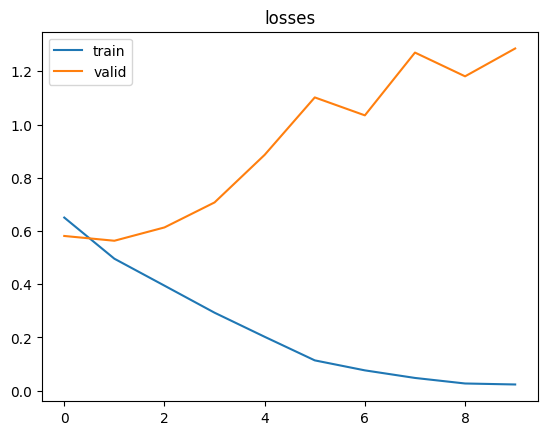

In [16]:
plt.title("losses")
plt.plot(losses["train_losses"], label="train")
plt.plot(losses["valid_losses"], label="valid")
plt.legend()
plt.show()

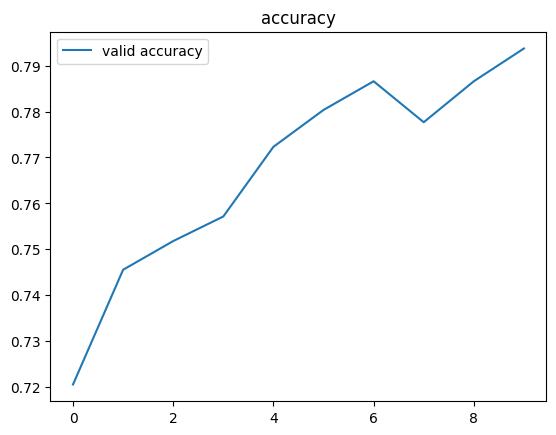

In [17]:
plt.title("accuracy")
plt.plot(losses["valid_acc"], label="valid accuracy")
plt.legend()
plt.show()

##Test

Test loss 1.433524000343691, Test accuracy: 0.7932518115942029
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3213
           1       0.80      0.31      0.45      1187

    accuracy                           0.79      4400
   macro avg       0.79      0.64      0.66      4400
weighted avg       0.79      0.79      0.76      4400

[[3118   95]
 [ 816  371]]


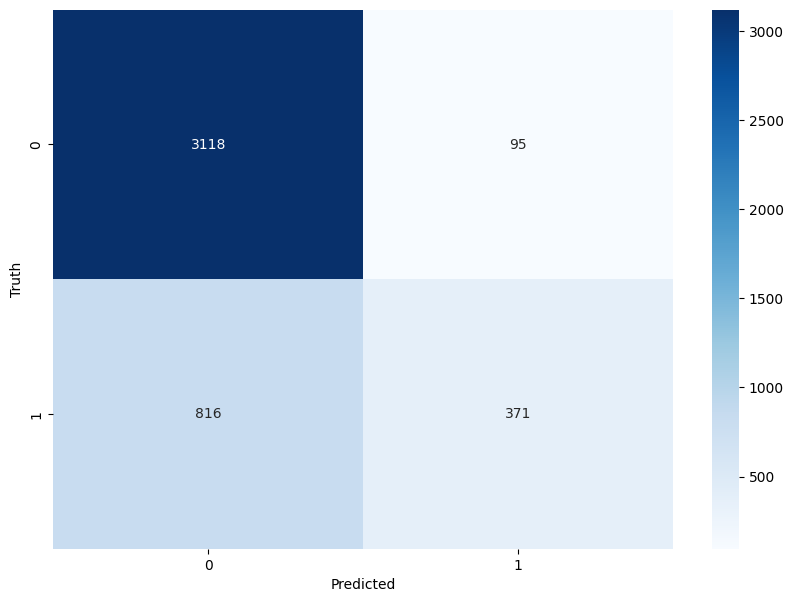

In [18]:
test_loss, test_acc,true_labels,pred_labels = trainer.evaluate(test_dataloader)
print(f"Test loss {test_loss}, Test accuracy: {test_acc}")
print(classification_report(true_labels,pred_labels))
print(confusion_matrix(true_labels,pred_labels))

import seaborn as sns
confusion__matrix = np.array([[3118, 95], [816, 371]])
plt.figure(figsize=(10,7))
sns.heatmap(confusion__matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#Random Baseline

In [22]:
train_texts = [sample['text'] for sample in train_dataset.samples]
train_labels =[sample['label'] for sample in train_dataset.samples]

test_texts = [sample['text'] for sample in test_dataset.samples]
test_labels = [sample['label'] for sample in test_dataset.samples]

valid_texts = [sample['text'] for sample in validation_dataset.samples]
valid_labels = [sample['label'] for sample in validation_dataset.samples]

# Importa il DummyClassifier da sklearn
from sklearn.dummy import DummyClassifier

# Crea un DummyClassifier con la strategia 'uniform'
clf_random = DummyClassifier(strategy='uniform', random_state=0)

# Addestra il classificatore
clf_random.fit(train_texts, train_labels)

# Prevedi sul set di validazione e di test
y_pred_valid_random = clf_random.predict(valid_texts)
y_pred_test_random = clf_random.predict(test_texts)

# Calcola l'accuratezza sul set di validazione e di test
acc_valid_random = accuracy_score(valid_labels, y_pred_valid_random)
acc_test_random = accuracy_score(test_labels, y_pred_test_random)

# Stampa le accuratezze
print(f"Random baseline accuracy on validation set: {acc_valid_random:.4f}")
print(f"Random baseline accuracy on test set: {acc_test_random:.4f}")

test_acc_formatted = "{:.4f}".format(test_acc)
valid_acc = losses["valid_acc"][-1]
print(f"Test Accuracy: {test_acc_formatted}")
print(f"Validation Accuracy: {valid_acc}")

if test_acc > float(acc_test_random):
  print("The model has an higher accuracy with respect to the baseline on test ")
else:
  print("The model has a lower accuracy with respect to the baseline on test")

Random baseline accuracy on validation set: 0.5196
Random baseline accuracy on test set: 0.5045
Test Accuracy: 0.7933
Validation Accuracy: 0.79375
The model has an higher accuracy with respect to the baseline on test 


#Word2Vec

In [20]:
# Assume that 'texts' is a list of sentences, where each sentence is a list of words
# This should be the same data you used to train your BiLSTM model
texts = [sample['text'].split() for sample in train_dataset.samples]

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.train(texts, total_examples=len(texts), epochs=10)

# For each text in your training set, compute the average Word2Vec vector
X_train = [np.mean([w2v_model.wv[word] for word in text if word in w2v_model.wv], axis=0) for text in texts]
y_train = [sample['label'] for sample in train_dataset.samples]

# Do the same for your test set
texts_test = [sample['text'].split() for sample in test_dataset.samples]
X_test = []
for text in texts_test:
    if any(word in w2v_model.wv for word in text):
        X_test.append(np.mean([w2v_model.wv[word] for word in text if word in w2v_model.wv], axis=0))
    else:
        X_test.append(np.zeros(100))  # Replace with a vector of zeros
y_test = [sample['label'] for sample in test_dataset.samples]

# Convert lists to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Train a logistic regression classifier
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

# Compute accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Word2Vec model: {accuracy}')

print(classification_report(y_test,y_pred))


Accuracy of Word2Vec model: 0.7268181818181818
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3213
           1       0.49      0.29      0.36      1187

    accuracy                           0.73      4400
   macro avg       0.63      0.59      0.60      4400
weighted avg       0.70      0.73      0.70      4400



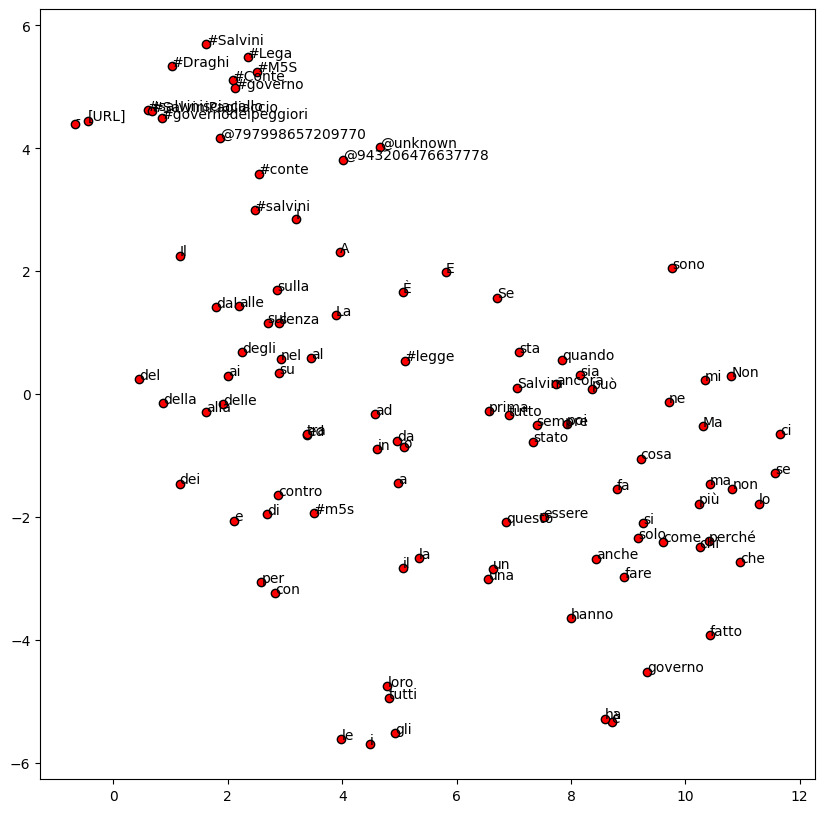

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Prendi le prime 100 parole dal tuo modello Word2Vec
words = list(w2v_model.wv.key_to_index.keys())[:100]

# Ottieni i vettori per queste parole dal tuo modello
vectors = [w2v_model.wv[word] for word in words]

# Rimuovi le parole che non hanno un vettore associato
words, vectors = zip(*[(word, vec) for word, vec in zip(words, vectors) if vec is not None])

# Converti le liste in array numpy
words = np.array(words)
vectors = np.array(vectors)

# Utilizza t-SNE per ridurre la dimensionalità dei vettori a 2
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors)

# Crea un grafico scatter con i risultati
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], edgecolors='k', c='r')
for word, (x, y) in zip(words, vectors_2d):
    plt.text(x, y, word)

plt.show()
